In [1]:
from pathlib import Path
from Bio.PDB import PDBList, PDBParser
import os
from tqdm import tqdm
import warnings
import pandas as pd
from Bio import SeqIO
from dotenv import load_dotenv
import os
import requests
import time
import json
from Bio.PDB.ic_rebuild import structure_rebuild_test
import numpy as np
import sys
import seaborn as sns
from Bio.Align import PairwiseAligner
import matplotlib.pyplot as plt

load_dotenv()
amino_acid_codes = json.load(open('amino_acid_codes.json'))

In [96]:
WINDOW_SIZE = 3
WINDOW_SIZE_CONTEXT = 7
WINDOW_SIZE_CONTEXT_SECONDARY = 5
PDBMINE_URL = os.getenv("PDBMINE_URL")
casp_protein_id = 'T1024'
casp_protein_id2 = 'T1024'
pdb_code = '6t1z'
alphafold_id = f'{casp_protein_id}TS427_1'
outdir = Path(f'csvs/{casp_protein_id}_win{WINDOW_SIZE}-{WINDOW_SIZE_CONTEXT}-{WINDOW_SIZE_CONTEXT_SECONDARY}')
if outdir.exists():
    print('Results already exist')
else:
    outdir.mkdir(exist_ok=False, parents=True)

In [3]:
# Get X-ray pdb
pdbl = PDBList()
parser = PDBParser()
xray_fn = pdbl.retrieve_pdb_file(pdb_code, pdir='pdb', file_format='pdb', obsolete=False)

# Get CASP predictions
predictions_url = f'https://predictioncenter.org/download_area/CASP14/predictions/regular/{casp_protein_id}.tar.gz'
predictions_dir = Path(f'./casp-predictions/')
if not (predictions_dir / casp_protein_id).exists():
    predictions_dir.mkdir(exist_ok=True)
    os.system(f'wget -O {predictions_dir}/{casp_protein_id}.tar.gz {predictions_url}')
    os.system(f'tar -xvf {predictions_dir}/{casp_protein_id}.tar.gz -C {predictions_dir}')

# Get CASP results
results_url = 'https://predictioncenter.org/download_area/CASP14/results/tables/casp14.res_tables.T.tar.gz'
results_dir = Path('casp-results')
if not results_dir.exists():
    results_dir.mkdir(exist_ok=True)
    os.system(f'wget -O {results_dir / "casp14.res_tables.T.tar.gz"} {results_url}')
    os.system(f'tar -xvf {results_dir / "casp14.res_tables.T.tar.gz"} -C {results_dir}')
results_file = results_dir / f'{casp_protein_id2}.txt'
results = pd.read_csv(results_file, delim_whitespace=True)
results = results[results.columns[1:]]

Structure exists: 'pdb/pdb6t1z.ent' 


/tmp/ipykernel_1116633/2368821838.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  results = pd.read_csv(results_file, delim_whitespace=True)


In [4]:
# Check alignment of casp prediction and x-ray structure
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    record = next(iter(SeqIO.parse(xray_fn, "pdb-seqres")))
    print("Record id %s, chain %s" % (record.id, record.annotations["chain"]))
    # print(record.seq)
    print(len(record.seq))
    residue_chain = str(record.seq)#[residue_range[0]-1:residue_range[1]]
    print(residue_chain)

    pred_files = list((predictions_dir / casp_protein_id).iterdir())
    i=0
    print(pred_files[i].name)
    pred_seq = str(next(iter(SeqIO.parse(pred_files[i], "pdb-atom"))).seq)
    print(pred_seq)

    aligner = PairwiseAligner()
    aligner.mode = 'global'
    alignments =  aligner.align(residue_chain, pred_seq)

    print(alignments[0])
    print('Large matches:')
    for i,((t1,t2),(q1,q2)) in enumerate(zip(*alignments[0].aligned)):
        if t2-t1 > 5:
            print(f'Match of length: {t2-t1} residues at position t={t1}, q={q1}')

Record id 6T1Z:A, chain A
411
GKEFWNLDKNLQLRLGIVFLGAFSYGTVFSSMTIYYNQYLGSAITGILLALSAVATFVAGILAGFFADRNGRKPVMVFGTIIQLLGAALAIASNLPGHVNPWSTFIAFLLISFGYNFVITAGNAMIIDASNAENRKVVFMLDYWAQNLSVILGAALGAWLFRPAFEALLVILLLTVLVSFFLTTFVMTETFKPTVKVDNIFQAYKTVLQDKTYMIFMGANIATTFIIMQFDNFLPVHLSNSFKTITFWGFEIYGQRMLTIYLILACVLVVLLMTTLNRLTKDWSHQKGFIWGSLFMAIGMIFSFLTTTFTPIFIAGIVYTLGEIVYTPSVQTLGADLMNPEKIGSYNGVAAIKMPIASILAGLLVSISPMIKAIGVSLVLALTEVLAIILVLVAVNRHQKTKLNLEVLFQG
T1024TS081_3
MKEFWNLDKNLQLRLGIVFLGAFSYGTVFSSMTIYYNQYLGSAITGILLALSAVATFVAGILAGFFADRNGRKPVMVFGTIIQLLGAALAIASNLPGHVNPWSTFIAFLLISFGYNFVITAGNAMIIDASNAENRKVVFMLDYWAQNLSVILGAALGAWLFRPAFEALLVILLLTVLVSFFLTTFVMTETFKPTVKVDEKAENIFQAYKTVLQDKTYMIFMGANIATTFIIMQFDNFLPVHLSNSFKTITFWGFEIYGQRMLTIYLILACVLVVLLMTTLNRLTKDWSHQKGFIWGSLFMAIGMIFSFLTTTFTPIFIAGIVYTLGEIVYTPSVQTLGADLMNPEKIGSYNGVAAIKMPIASILAGLLVSISPMIKAIGVSLVLALTEVLAIILVLVAVNRHQKTKLN
target            0 G-KEFWNLDKNLQLRLGIVFLGAFSYGTVFSSMTIYYNQYLGSAITGILLALSAVATFVA
                  0 --|||||||||||||||||||||||||||||||||

# Collect Dihedrals - Xray and predictions

In [52]:
xray_structure = parser.get_structure(pdb_code, xray_fn)
xray_chain = list(xray_structure[0].get_chains())[0]

def get_phi_psi_for_structure(protein_structure, protein_id):
    protein_structure.atom_to_internal_coordinates(verbose=False)
    resultDict = structure_rebuild_test(protein_structure)
    if not resultDict['pass']:
        raise Exception('Failed to rebuild')
    residues = list(protein_structure.get_residues())
    phi_psi_ = []
    for i in range(WINDOW_SIZE_CONTEXT//2, len(residues) - WINDOW_SIZE_CONTEXT // 2):
        # Convert 3 char codes to 1 char codes
        seq = ''.join([amino_acid_codes.get(r.resname, 'X') for r in residues[i-WINDOW_SIZE//2:i+WINDOW_SIZE//2+1]])
        seq_ctxt = ''.join([amino_acid_codes.get(r.resname, 'X') for r in residues[i-WINDOW_SIZE_CONTEXT//2:i+WINDOW_SIZE_CONTEXT//2+1]])
        # Get the center residue
        res = seq[-WINDOW_SIZE//2]
        if not residues[i].internal_coord:
            psi,phi = np.nan, np.nan
        else:
            psi = residues[i].internal_coord.get_angle("psi")
            phi = residues[i].internal_coord.get_angle("phi")
            psi = psi if psi else np.nan # if psi is None, set it to np.nan
            phi = phi if phi else np.nan # if phi is None, set it to np.nan
        phi_psi_.append([i, seq, seq_ctxt, res, phi, psi, xray_chain.id, protein_id])
    return phi_psi_

xray_phi_psi = get_phi_psi_for_structure(xray_chain, pdb_code)
xray_phi_psi = pd.DataFrame(xray_phi_psi, columns=['pos', 'seq', 'seq_ctxt', 'res', 'phi', 'psi', 'chain', 'protein_id'])
xray_phi_psi.to_csv(outdir / 'xray_phi_psi.csv', index=False)

In [53]:
# Get phi_psi's of each prediction
phi_psi_predictions_ = []
for prediction_pdb in tqdm((predictions_dir / casp_protein_id).iterdir()):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        prediction = parser.get_structure(prediction_pdb.name, prediction_pdb)
        try:
            chain = list(prediction[0].get_chains())[0]
            phi_psi_predictions_ += get_phi_psi_for_structure(chain, prediction.id)
        except Exception as e:
            print(e)
phi_psi_predictions = pd.DataFrame(phi_psi_predictions_, columns=['pos', 'seq', 'seq_ctxt', 'res', 'phi', 'psi', 'chain', 'protein_id'])
phi_psi_predictions.to_csv(outdir / 'phi_psi_predictions.csv', index=False)

76it [01:02,  1.25it/s]

Failed to rebuild


97it [01:20,  1.22it/s]

Failed to rebuild


103it [01:25,  1.14it/s]

Failed to rebuild


119it [01:38,  1.28it/s]

Failed to rebuild


129it [01:47,  1.14it/s]

Failed to rebuild


131it [01:48,  1.20it/s]

Failed to rebuild


150it [02:04,  1.22it/s]

Failed to rebuild


152it [02:06,  1.15it/s]

Failed to rebuild


164it [02:17,  1.18it/s]

Failed to rebuild


173it [02:24,  1.22it/s]

Failed to rebuild


174it [02:25,  1.22it/s]

Failed to rebuild


188it [02:37,  1.15it/s]

Failed to rebuild


239it [03:21,  1.10it/s]

Failed to rebuild


296it [04:11,  1.20it/s]

Failed to rebuild


299it [04:13,  1.25it/s]

Failed to rebuild


307it [04:20,  1.28it/s]

Failed to rebuild


312it [04:25,  1.08it/s]

Failed to rebuild


319it [04:31,  1.07it/s]

Failed to rebuild


350it [04:58,  1.20it/s]

Failed to rebuild


420it [06:01,  1.14it/s]

Failed to rebuild


425it [06:05,  1.23it/s]

Failed to rebuild


436it [06:16,  1.06it/s]

Failed to rebuild


445it [06:24,  1.07it/s]

Failed to rebuild


474it [06:50,  1.08it/s]

Failed to rebuild


491it [07:05,  1.01it/s]

Failed to rebuild


503it [07:16,  1.15it/s]

Failed to rebuild


508it [07:20,  1.11it/s]

Failed to rebuild


509it [07:21,  1.14it/s]

Failed to rebuild


512it [07:24,  1.15it/s]


# PDBMine

In [95]:
# Test connection
response = requests.get(PDBMINE_URL + f'/v1/api/protein/{pdb_code}', verify=False)
assert(response.ok)
protein_data = response.json()

In [55]:
# Get Phi-Psi distribution from PDBMine

def query_pdbmine(window_size):
    record = next(iter(SeqIO.parse(xray_fn, "pdb-seqres")))
    residue_chain = str(record.seq)

    code_length = 1
    broken_chains = []

    # break chain into sections of length 100 - for memory reasons
    # overlap by window_size-1
    for i in range(0, len(residue_chain), 100-window_size+1):
        broken_chains.append(residue_chain[i:i+100])

    match_outdir = outdir / f'matches-{window_size}'
    match_outdir.mkdir(exist_ok=False)

    for i,chain in enumerate(tqdm(broken_chains)):
        if len(chain) < window_size: # in case the last chain is too short
            continue

        response = requests.post(
            PDBMINE_URL + '/v1/api/query',
            json={
                "residueChain": chain,
                "codeLength": code_length,
                "windowSize": window_size
            }
        )
        assert(response.ok)
        print(response.json())
        query_id = response.json().get('queryID')
        assert(query_id)

        time.sleep(60)
        while(True):
            response = requests.get(PDBMINE_URL + f'/v1/api/query/{query_id}')
            if response.ok:
                matches = response.json()['frames']
                break
            else:
                print('Waiting')
                time.sleep(15)
        print(f'Received matches - {i}')
        json.dump(matches, open(match_outdir / f'matches-win{window_size}_{i}.json', 'w'), indent=4)
query_pdbmine(WINDOW_SIZE)
query_pdbmine(WINDOW_SIZE_CONTEXT)
query_pdbmine(WINDOW_SIZE_CONTEXT_SECONDARY)

  0%|          | 0/5 [00:00<?, ?it/s]

{'status': 'Running', 'queryID': '5deabaa9-07e0-11ef-8a9b-0242ac110002'}


 20%|██        | 1/5 [01:00<04:00, 60.07s/it]

Received matches - 0
{'status': 'Running', 'queryID': '81b8fe45-07e0-11ef-8a9b-0242ac110002'}


 40%|████      | 2/5 [02:00<03:00, 60.07s/it]

Received matches - 1
{'status': 'Running', 'queryID': 'a5878f80-07e0-11ef-8a9b-0242ac110002'}


 60%|██████    | 3/5 [03:00<02:00, 60.05s/it]

Received matches - 2
{'status': 'Running', 'queryID': 'c94f0e3e-07e0-11ef-8a9b-0242ac110002'}


 80%|████████  | 4/5 [04:00<01:00, 60.05s/it]

Received matches - 3
{'status': 'Running', 'queryID': 'ed17ccb6-07e0-11ef-8a9b-0242ac110002'}


100%|██████████| 5/5 [05:00<00:00, 60.06s/it]

Received matches - 4


In [58]:
# Get phi-psi from PDBMine matches
# If any sequence appears twice, only take the first one bc the distribution is the same
def get_phi_psi_mined(window_size):
    seqs = []
    phi_psi_mined = []
    for matches in Path(outdir / f'matches-{window_size}').iterdir():
        matches = json.load(matches.open())
        for seq_win,v in matches.items():
            seq = seq_win[4:]
            if seq in seqs:
                continue
            seqs.append(seq)
            for protein,seq_matches in v.items():
                protein_id, chain = protein.split('_')
                if protein_id.lower() == pdb_code.lower(): # skip the protein we're looking at
                    continue
                for seq_match in seq_matches:
                    center_res = seq_match[window_size//2]
                    res, phi, psi = center_res.values()
                    phi_psi_mined.append([seq, res, phi, psi, chain, protein_id])
    phi_psi_mined = pd.DataFrame(phi_psi_mined, columns=['seq', 'res', 'phi', 'psi', 'chain', 'protein_id'])
    phi_psi_mined.to_csv(outdir / f'phi_psi_mined_win{window_size}.csv', index=False)
    return phi_psi_mined

phi_psi_mined = get_phi_psi_mined(WINDOW_SIZE)
phi_psi_mined_ctxt = get_phi_psi_mined(WINDOW_SIZE_CONTEXT)
phi_psi_mined_ctxt = get_phi_psi_mined(WINDOW_SIZE_CONTEXT_SECONDARY)

# Results

In [97]:
phi_psi_mined = pd.read_csv(outdir / f'phi_psi_mined_win{WINDOW_SIZE}.csv')
phi_psi_mined_ctxt = pd.read_csv(outdir / f'phi_psi_mined_win{WINDOW_SIZE_CONTEXT}.csv')
phi_psi_mined_ctxt_2 = pd.read_csv(outdir / f'phi_psi_mined_win{WINDOW_SIZE_CONTEXT_SECONDARY}.csv')
phi_psi_predictions = pd.read_csv(outdir / 'phi_psi_predictions.csv')
xray_phi_psi = pd.read_csv(outdir / 'xray_phi_psi.csv')
overlapping_seqs = list(set(phi_psi_mined_ctxt.seq) & set(phi_psi_predictions.seq_ctxt) & set(xray_phi_psi.seq_ctxt))

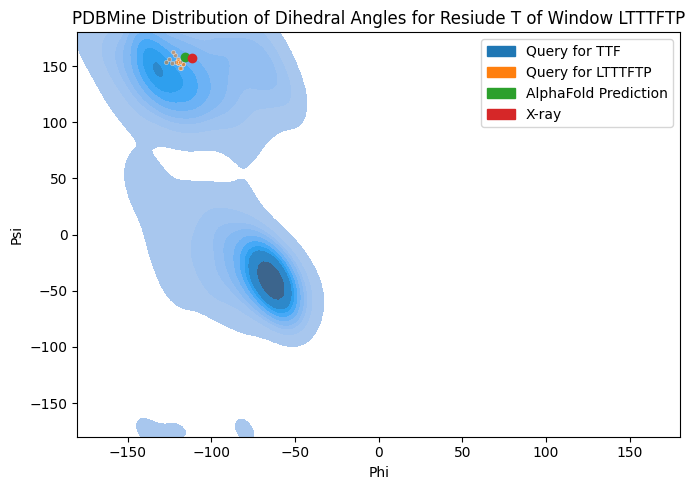

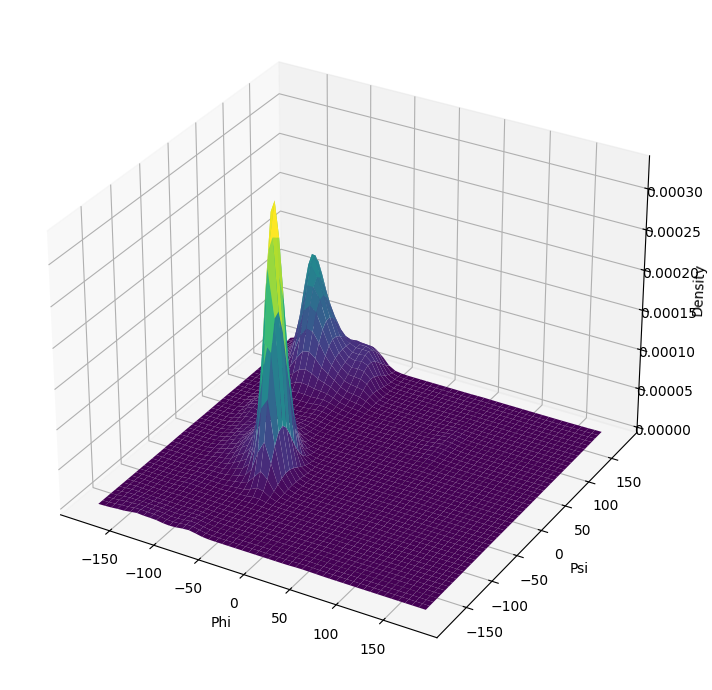

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

def plot_one_dist(seq, pred_id, pred_name=None, axlims=None):
    pred_name = pred_name or pred_id
    inner_seq = seq[WINDOW_SIZE_CONTEXT // 2 - WINDOW_SIZE // 2:WINDOW_SIZE_CONTEXT // 2 + WINDOW_SIZE // 2 + 1]
    phi_psi_dist = phi_psi_mined[phi_psi_mined.seq == inner_seq]
    phi_psi_ctxt_dist = phi_psi_mined_ctxt[phi_psi_mined_ctxt.seq == seq]
    phi_psi_alpha = phi_psi_predictions[(phi_psi_predictions.protein_id == pred_id) & (phi_psi_predictions.seq_ctxt == seq)]
    xray_phi_psi_seq = xray_phi_psi[xray_phi_psi.seq_ctxt == seq]

    fig, ax = plt.subplots(figsize=(7,5))
    # sns.jointplot(data=phi_psi_dist, x='phi', y='psi', kind='kde')
    sns.scatterplot(data=phi_psi_ctxt_dist, x='phi', y='psi', ax=ax, color=colors[1],zorder=5, alpha=0.5, marker='.')
    sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', ax=ax, fill=True, color=colors[0])
    
    ax.plot(phi_psi_alpha.phi, phi_psi_alpha.psi, 'o', color=colors[2], label='AlphaFold Prediction', zorder=10)
    ax.plot(xray_phi_psi_seq.phi, xray_phi_psi_seq.psi, 'o', color=colors[3], label='X-ray', zorder=10)
    ax.legend(handles=[
        mpatches.Patch(color=colors[0], label=f'Query for {inner_seq}'),
        mpatches.Patch(color=colors[1], label=f'Query for {seq}'),
        mpatches.Patch(color=colors[2], label='AlphaFold Prediction'),
        mpatches.Patch(color=colors[3], label='X-ray')
    ])
    ax.set_title(f'PDBMine Distribution of Dihedral Angles for Resiude {seq[WINDOW_SIZE_CONTEXT//2]} of Window {seq}')

    ax.set_xlabel('Phi')
    ax.set_ylabel('Psi')

    if axlims:
        ax.set_xlim(axlims[0][0], axlims[0][1])
        ax.set_ylim(axlims[1][0], axlims[1][1])

    plt.tight_layout()
    plt.show()

def plot_one_dist_3d(seq, pred_id, pred_name=None):
    seq = seq[WINDOW_SIZE_CONTEXT // 2 - WINDOW_SIZE // 2:WINDOW_SIZE_CONTEXT // 2 + WINDOW_SIZE // 2 + 1]
    pred_name = pred_name or pred_id
    phi_psi_dist = phi_psi_mined[phi_psi_mined.seq == seq]

    x = phi_psi_dist[['phi','psi']].values.T
    kde = gaussian_kde(x)

    x_grid, y_grid = np.meshgrid(np.linspace(-180, 180, 50), np.linspace(-180, 180, 50))
    grid = np.vstack([x_grid.ravel(), y_grid.ravel()])
    z = kde(grid).reshape(x_grid.shape)

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x_grid, y_grid, z, cmap='viridis')
    ax.set_xlabel('Phi')
    ax.set_ylabel('Psi')
    ax.set_zlabel('Density')
    plt.tight_layout()
    plt.show()

seq = overlapping_seqs[1]
plot_one_dist(seq, alphafold_id, 'AlphaFold', axlims=((-180, 180), (-180, 180)))
plot_one_dist_3d(seq, alphafold_id, 'AlphaFold')

GLL (87779, 2)
LAGLLVS (1, 2)
AGLLV (510, 2)
Not enough context data for KDE - Using secondary window size
xray: 107.14420357723267
alpha: 97.93608841401826
preds:
                 0
count  467.000000
mean   103.534829
std     16.901962
min      1.349465
25%    101.828783
50%    105.204093
75%    109.120412
max    177.019549
{0: 57190, 2: 25911, 12: 288, 15: 207, 121: 140, 114: 64, 110: 61, 191: 41, 47: 38, 10: 35, 166: 34, 26: 33, 41: 31, 96: 27, 21: 24, 11: 24, 109: 21, 156: 20, 173: 19, 23: 19, 144: 18, 34: 18, 46: 16, 145: 16, 118: 16, 271: 16, 289: 16, 65: 15, 160: 15, 7: 15, 182: 15, 39: 15, 224: 14, 95: 14, 298: 14, 174: 14, 99: 13, 97: 13, 295: 13, 43: 13, 208: 12, 127: 12, 69: 12, 102: 12, 27: 12, 344: 12, 210: 11, 14: 11, 142: 11, 356: 11, 252: 10, 284: 10, 52: 10, 54: 10, 113: 10, 317: 10, 143: 10, 123: 10, 335: 9, 296: 9, 18: 9, 86: 9, 63: 9, 190: 9, 90: 9, 178: 9, 334: 9, 361: 9, 293: 9, 306: 9, 326: 9, 299: 8, 313: 8, 269: 8, 22: 8, 312: 8, 223: 8, 277: 8, 103: 8, 84: 8, 

/tmp/ipykernel_1116633/2321541516.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis_cmap = plt.cm.get_cmap('viridis')


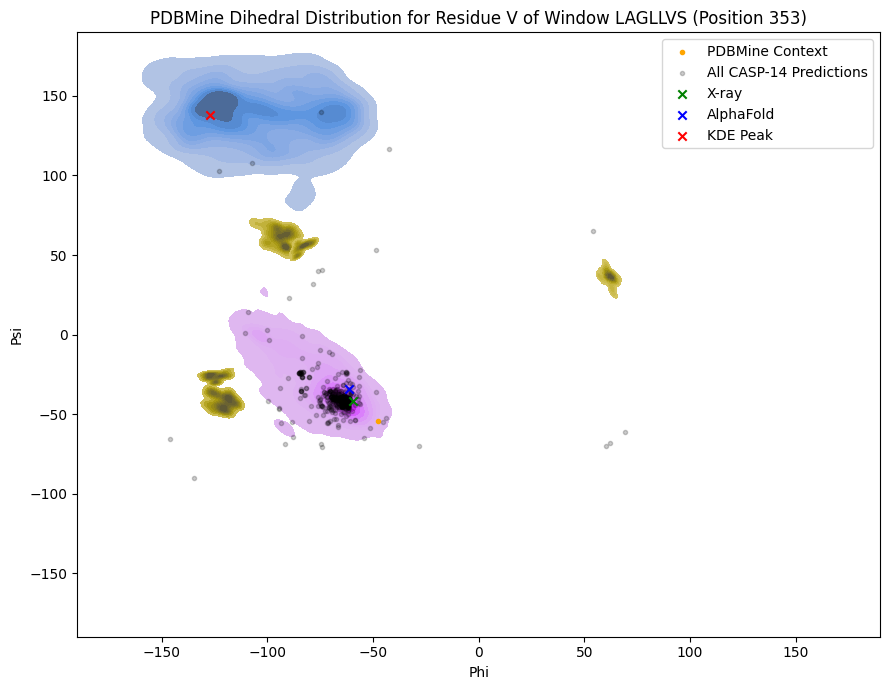

In [117]:
# For one window
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde



def plot_clusters_for_window(seq, pred_id, pred_name=None, eps=10, axlims=None, zoom=False, zoom_lims=None):
    inner_seq = seq[WINDOW_SIZE_CONTEXT // 2 - WINDOW_SIZE // 2:WINDOW_SIZE_CONTEXT // 2 + WINDOW_SIZE // 2 + 1]
    secondary_inner_seq = seq[WINDOW_SIZE_CONTEXT // 2 - WINDOW_SIZE_CONTEXT_SECONDARY // 2:WINDOW_SIZE_CONTEXT_SECONDARY // 2 + WINDOW_SIZE_CONTEXT // 2 + 1]
    pred_name = pred_name or pred_id
    phi_psi_dist = phi_psi_mined.loc[phi_psi_mined.seq == inner_seq][['phi','psi']]
    phi_psi_ctxt_dist = phi_psi_mined_ctxt.loc[phi_psi_mined_ctxt.seq == seq][['phi','psi']]
    phi_psi_ctxt_dist_2 = phi_psi_mined_ctxt_2.loc[phi_psi_mined_ctxt_2.seq == secondary_inner_seq][['phi','psi']]
    print(inner_seq, phi_psi_dist.shape)
    print(seq, phi_psi_ctxt_dist.shape)
    print(secondary_inner_seq, phi_psi_ctxt_dist_2.shape)

    # Find clusters
    clustering = DBSCAN(eps=eps, min_samples=3).fit(phi_psi_dist.values)
    phi_psi_dist['cluster'] = clustering.labels_

    # Find most probable data point from context dist and the cluster it belongs to
    if phi_psi_ctxt_dist.shape[0] > 2:
        kernel = gaussian_kde(phi_psi_ctxt_dist[['phi','psi']].T)
    elif phi_psi_ctxt_dist_2.shape[0] > 2:
        print('Not enough context data for KDE - Using secondary window size')
        kernel = gaussian_kde(phi_psi_ctxt_dist_2[['phi','psi']].T)
    else:
        print('Not enough secondary context data for KDE - Using base window size')
        kernel = gaussian_kde(phi_psi_dist[['phi','psi']].T)
    phi_psi_most_likely_idx = kernel(phi_psi_dist[['phi','psi']].T).argmax()
    phi_psi_c = phi_psi_dist.loc[phi_psi_dist.cluster == phi_psi_dist.iloc[phi_psi_most_likely_idx].cluster, ['phi','psi']].values

    # Mahalanobis distance to most common cluster
    cov = np.cov(phi_psi_c.T)
    icov = np.linalg.inv(cov)

    # xray
    xray = xray_phi_psi[xray_phi_psi.seq_ctxt == seq][['phi','psi']].values
    pos = xray_phi_psi[xray_phi_psi.seq_ctxt == seq]['pos'].values[0]
    md_xray = (xray - phi_psi_c.mean(axis=0)) @ icov @ (xray - phi_psi_c.mean(axis=0)).T

    # alphafold to most common cluster
    alpha = phi_psi_predictions[(phi_psi_predictions.protein_id == alphafold_id) & (phi_psi_predictions.seq_ctxt == seq)][['phi','psi']].values
    md_alpha = (alpha - phi_psi_c.mean(axis=0)) @ icov @ (alpha - phi_psi_c.mean(axis=0)).T

    # Other predictions
    preds = phi_psi_predictions[phi_psi_predictions.seq_ctxt == seq][['phi','psi']].values
    icov = np.repeat(np.expand_dims(icov, 0), preds.shape[0], axis=0) # expand for batch matrix multiplication
    md_preds = (np.expand_dims((preds - phi_psi_c.mean(axis=0)), 1) @ icov @ np.expand_dims((preds - phi_psi_c.mean(axis=0)), 2)).squeeze()
    print('xray:', md_xray[0,0])
    print('alpha:', md_alpha[0,0])
    print('preds:\n', pd.DataFrame(md_preds).describe())

    value_counts = phi_psi_dist[phi_psi_dist.cluster != -1].cluster.value_counts().sort_values(ascending=False)
    print(value_counts.to_dict())
    cs_to_keep = value_counts[value_counts > 50].index
    if not zoom:
        fig, ax = plt.subplots(figsize=(9,7))
        viridis_cmap = plt.cm.get_cmap('viridis')
        for c in cs_to_keep:
            color = viridis_cmap(c / len(cs_to_keep))
            sns.kdeplot(data=phi_psi_dist[phi_psi_dist.cluster == c], x='phi', y='psi', ax=ax, color=color, fill=True, legend=False)
        # sns.kdeplot(data=phi_psi_dist[phi_psi_dist.cluster.isin(cs_to_keep)], x='phi', y='psi', hue='cluster', palette='viridis', ax=ax, fill=True, legend=False)
        ax.scatter(phi_psi_ctxt_dist.phi, phi_psi_ctxt_dist.psi, color='orange', marker='.', label='PDBMine Context')
        ax.scatter(preds[:,0], preds[:,1], color='black', marker='.', alpha=0.2, label='All CASP-14 Predictions')
        ax.scatter(xray[0,0], xray[0,1], color='green', marker='x', label='X-ray')
        ax.scatter(alpha[0,0], alpha[0,1], color='blue', marker='x', label='AlphaFold')
        ax.scatter(phi_psi_dist.iloc[phi_psi_most_likely_idx].phi, phi_psi_dist.iloc[phi_psi_most_likely_idx].psi, color='red', marker='x', label='KDE Peak')

        ax.set_xlabel('Phi')
        ax.set_ylabel('Psi')
        ax.set_title(f'PDBMine Dihedral Distribution for Residue {seq[-WINDOW_SIZE//2]} of Window {seq} (Position {pos})')
        ax.legend()
        if axlims:
            ax.set_xlim(axlims[0][0], axlims[0][1])
            ax.set_ylim(axlims[1][0], axlims[1][1])
        plt.tight_layout()
    else:
        # Zoomed in
        fig, ax = plt.subplots(figsize=(7,5))
        sns.kdeplot(data=phi_psi_dist[phi_psi_dist.cluster.isin(cs_to_keep)], x='phi', y='psi', hue='cluster', palette='viridis', ax=ax, fill=True, legend=False)
        ax.scatter(phi_psi_dist.iloc[phi_psi_most_likely_idx].phi, phi_psi_dist.iloc[phi_psi_most_likely_idx].psi, color='red', marker='x', s=100, label='KDE Peak')
        ax.scatter(preds[:,0], preds[:,1], color='black', marker='.', alpha=0.2, label='All CASP-14 Predictions')
        ax.scatter(xray[0,0], xray[0,1], color='green', marker='x', s=100, label='X-ray')
        ax.scatter(alpha[0,0], alpha[0,1], color='blue', marker='x', s=100, label='AlphaFold')
        ax.set_xlim(zoom_lims[0][0], zoom_lims[0][1])
        ax.set_ylim(zoom_lims[1][0], zoom_lims[1][1])
        ax.axis('off')
        plt.tight_layout()
    plt.show()
seq = overlapping_seqs[10]
plot_clusters_for_window(seq, alphafold_id, 'AlphaFold', eps=1.5, axlims=((-190, 190), (-190, 190)))
# plot_clusters_for_window(seq, alphafold_id, 'AlphaFold', eps=10, zoom=True, zoom_lims=((-180, -10), (-100, 200)))

In [ ]:
def get_md_for_all_predictions(eps=10):
    phi_psi_predictions['md'] = np.nan
    xray_phi_psi['md'] = np.nan
    for i,seq in tqdm(enumerate(phi_psi_predictions.seq_ctxt.unique())):
        inner_seq = seq[WINDOW_SIZE_CONTEXT // 2 - WINDOW_SIZE // 2:WINDOW_SIZE_CONTEXT // 2 + WINDOW_SIZE // 2 + 1]
        secondary_inner_seq = seq[WINDOW_SIZE_CONTEXT // 2 - WINDOW_SIZE_CONTEXT_SECONDARY // 2:WINDOW_SIZE_CONTEXT_SECONDARY // 2 + WINDOW_SIZE_CONTEXT // 2 + 1]
        phi_psi_dist = phi_psi_mined.loc[phi_psi_mined.seq == inner_seq][['phi','psi']]
        phi_psi_ctxt_dist = phi_psi_mined_ctxt.loc[phi_psi_mined_ctxt.seq == seq][['phi','psi']]
        phi_psi_ctxt_dist_2 = phi_psi_mined_ctxt_2.loc[phi_psi_mined_ctxt_2.seq == secondary_inner_seq][['phi','psi']]
        print(f'{seq}: {phi_psi_dist.shape[0]} {phi_psi_ctxt_dist.shape[0]} {phi_psi_ctxt_dist_2.shape[0]}')

        if phi_psi_ctxt_dist.shape[0] > 2:
            print('Enough context data for KDE - Using Full Context')
            dist = phi_psi_ctxt_dist[['phi','psi']].values.T
        elif phi_psi_ctxt_dist_2.shape[0] > 2:
            dist = phi_psi_ctxt_dist_2[['phi','psi']].values.T
        elif phi_psi_dist.shape[0] > 2:
            print('Not enough secondary context data for KDE - Using base window size')
            dist = phi_psi_dist[['phi','psi']].values.T
        else:
            print(f'Skipping {seq} - not enough data points')
            # leave as nan
            continue

        xray = xray_phi_psi[xray_phi_psi.seq_ctxt == seq][['phi','psi']].values
        preds = phi_psi_predictions.loc[phi_psi_predictions.seq_ctxt == seq][['phi','psi']].values
        print(xray.shape, preds.shape, dist.shape)

        # Find clusters
        clustering = DBSCAN(eps=eps, min_samples=3).fit(phi_psi_dist.values)
        phi_psi_dist['cluster'] = clustering.labels_

        # Find most probable data point from context dist and the cluster it belongs to
        kernel = gaussian_kde(dist)
        phi_psi_most_likely_idx = kernel(phi_psi_dist[['phi','psi']].T).argmax()
        phi_psi_c = phi_psi_dist.loc[phi_psi_dist.cluster == phi_psi_dist.iloc[phi_psi_most_likely_idx].cluster, ['phi','psi']].values

        # Mahalanobis distance to most common cluster
        cov = np.cov(phi_psi_c.T)
        if np.linalg.det(cov) == 0:
            print(f'Skipping {seq} - singular matrix')
            # leave as nan
            continue
        icov = np.linalg.inv(cov)
        mean = phi_psi_c.mean(axis=0)

        md_xray = np.nan
        if xray.shape[0] > 0:
            # xray
            md_xray = (xray - mean) @ icov @ (xray - mean).T
            if np.any(md_xray < 0):
                md_xray = np.nan
            else:
                md_xray = np.sqrt(md_xray)[0,0]
            xray_phi_psi.loc[xray_phi_psi.seq_ctxt == seq, 'md'] = md_xray
        else:
            print(f'No xray seq {seq}')

        # All predictions
        if preds.shape[0] > 0:
            md = (np.expand_dims((preds - mean), 1) @ icov @ np.expand_dims((preds - mean), 2)).squeeze()
            if np.any(md < 0):
                md = np.nan
            else:
                md = np.sqrt(md)
            phi_psi_predictions.loc[phi_psi_predictions.seq_ctxt == seq, 'md'] = md
        else:
            print(f'No predictions seq {seq}')
        
eps=1.5
get_md_for_all_predictions(eps)
# phi_psi_predictions.to_csv(outdir / f'phi_psi_predictions_md-eps{eps}.csv', index=False)
# xray_phi_psi.to_csv(outdir / f'xray_phi_psi_md-eps{eps}.csv', index=False)

In [178]:
eps=1.5
phi_psi_predictions = pd.read_csv(outdir / f'phi_psi_predictions_md-eps{eps}.csv')
xray_phi_psi = pd.read_csv(outdir / f'xray_phi_psi_md-eps{eps}.csv')

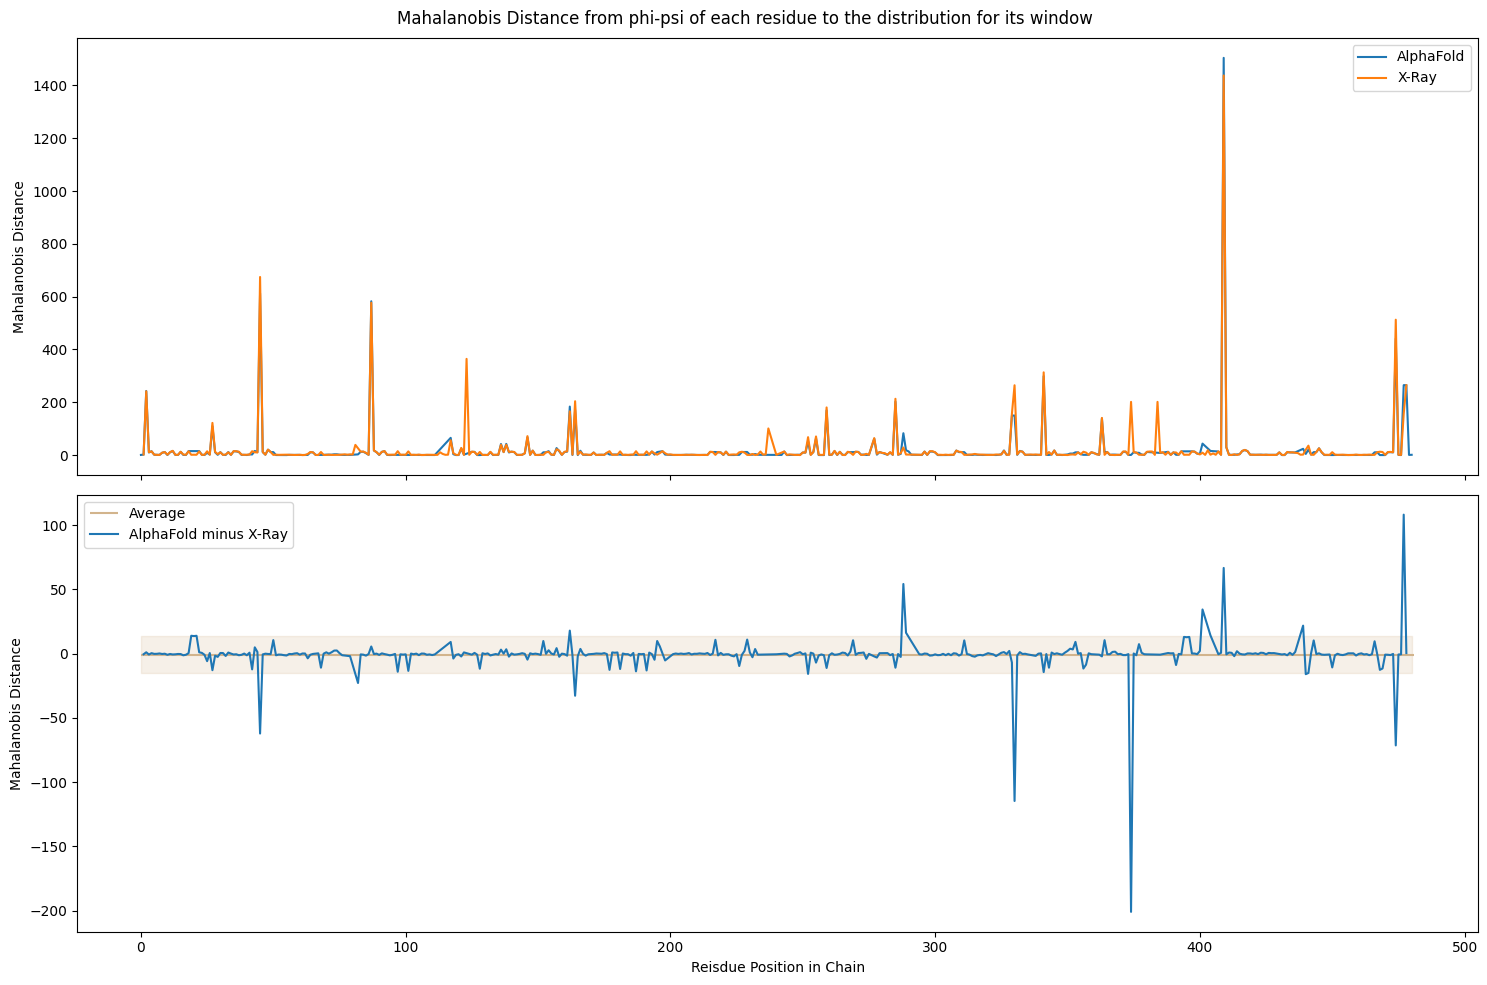

In [179]:
# Plot xray vs prediction md for each residue of one prediction
def plot_res_vs_md(pred_id, pred_name=None, highlight_res=None):
    pred_name = pred_name or pred_id
    phi_psi_predictions['Source'] = 'CASP Prediction'
    phi_psi_predictions.loc[phi_psi_predictions.protein_id == pred_id, 'Source'] = pred_name
    alpha = phi_psi_predictions.loc[phi_psi_predictions.protein_id == pred_id]
    xray_phi_psi['Source'] = 'X-Ray'
    both = pd.merge(alpha, xray_phi_psi, how='inner', on=['seq','seq'], suffixes=('_alpha','_xray'))
    both['md_diff'] = both['md_alpha'] - both['md_xray']
    fig, axes = plt.subplots(2, figsize=(15,10), sharex=True)
    sns.lineplot(data=both.reset_index(), x='index', y='md_alpha', ax=axes[0], label=pred_name)
    sns.lineplot(data=both.reset_index(), x='index', y='md_xray', ax=axes[0], label='X-Ray')
    axes[0].set_ylabel('Mahalanobis Distance')
    axes[1].hlines(both['md_diff'].mean(), xmin=0, xmax=len(both), color='tan', label='Average')
    axes[1].fill_between(x=both.index, y1=both['md_diff'].mean() + both['md_diff'].std(), y2=both['md_diff'].mean() - both['md_diff'].std(), color='tan', alpha=0.2)
    sns.lineplot(data=both.reset_index(), x='index', y='md_diff', ax=axes[1], label=f'{pred_name} minus X-Ray')
    axes[1].set_ylabel('Mahalanobis Distance')
    axes[1].set_xlabel('Reisdue Position in Chain')
    fig.suptitle('Mahalanobis Distance from phi-psi of each residue to the distribution for its window')
    plt.tight_layout()

    if highlight_res:
        for ax in axes:
            ax.axvspan(highlight_res[0], highlight_res[1], color='red', alpha=0.2)

plot_res_vs_md('T1024TS288_2', pred_name="AlphaFold")
# NOTE: for presentation, highlight area around res-300 to show this is where alphafold did bad

In [186]:
phi_psi_predictions[phi_psi_predictions.protein_id == id].md.quantile(0.75)

12.382031780075167

In [187]:
id = 'T1024TS081_3'
def q3_filter_md(df):
    return df[df.md < df.md.quantile(0.75)]
q3_filter_md(phi_psi_predictions[phi_psi_predictions.protein_id == id]).describe()

,pos,phi,psi,md
count,295.000000,295.000000,295.000000,295.000000
mean,204.410169,-67.351705,-25.340766,3.818696
std,117.041788,27.183545,52.353754,4.087826
min,6.000000,-176.870810,-175.142788,0.177190
25%,104.000000,-70.769911,-47.458357,0.914022
50%,207.000000,-63.058787,-40.844583,1.483553
75%,307.500000,-59.092057,-26.991102,7.300485
max,404.000000,93.300113,177.621137,12.364072


R-squared: 0.284104


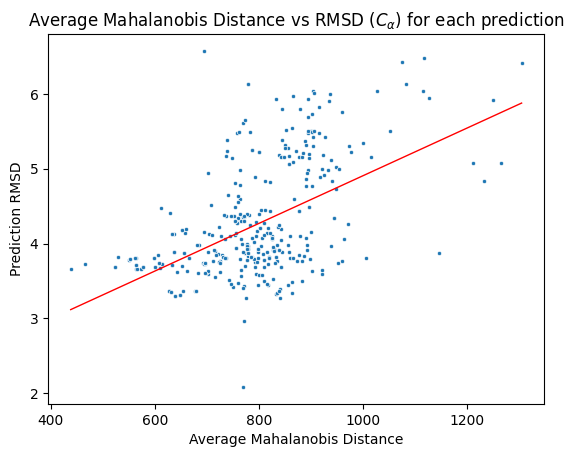

In [218]:
# Compare rmsd and mahalanobis distance
import matplotlib.pyplot as plt
from scipy.stats import linregress

def filter_and_sum(series):
    series = series[series < series.quantile(0.75)]
    return series.sum()

def plot_md_vs_rmsd(rmsd_lim=np.inf, md_lim=np.inf):
    results['Model'] = results['Model'].apply(lambda x: x.split('-')[0])
    #group_maha = phi_psi_predictions.groupby(['protein_id'], as_index=False).sum(numeric_only=True)#.sort_values('mahalanobis_dist').set_index('protein_id').dropna()
    group_maha = phi_psi_predictions.groupby('protein_id', as_index=False).agg({'md': filter_and_sum})
    group_maha = group_maha.merge(results[['Model', 'RMS_CA']], left_on='protein_id', right_on='Model', how='inner')
    group_maha = group_maha[(group_maha.RMS_CA < rmsd_lim) * (group_maha.md < md_lim)].dropna()
    fig, ax = plt.subplots()
    sns.scatterplot(data=group_maha, x='md', y='RMS_CA', ax=ax, marker='.', legend=False)
    sns.regplot(data=group_maha, x='md', y='RMS_CA', ax=ax, ci=False, scatter=False, color='red', line_kws={'lw':1}, label='Regression Line')
    ax.set_xlabel('Average Mahalanobis Distance')
    ax.set_ylabel('Prediction RMSD')
    ax.set_title(r'Average Mahalanobis Distance vs RMSD ($C_{\alpha}$) for each prediction')
    regr = linregress(group_maha.md, group_maha.RMS_CA)
    print(f"R-squared: {regr.rvalue**2:.6f}")
plot_md_vs_rmsd(7)
# ax.set_xlim((0.8,1.4))
# ax.set_ylim((0,6))

# Specific Cases

(16331, 6)
(45097, 6)
(16686, 6)
(22667, 6)


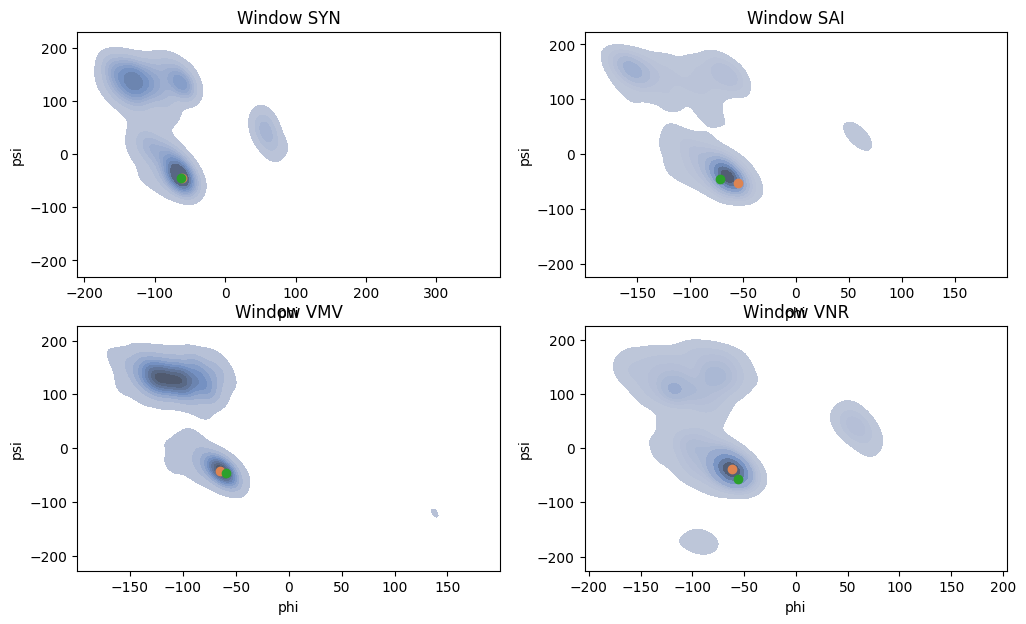

In [227]:
# plot dists with highest mahalanobis distance for alphafold
phi_psi_alpha = phi_psi_predictions[phi_psi_predictions.protein_id == alphafold_id]
seqs_with_highest_maha = phi_psi_alpha.sort_values('md', ascending=False).head(16).seq.values
m = 0
fig, axes = plt.subplots(2,2,figsize=(12,7))
for i,seq in enumerate(seqs_with_highest_maha[m:m+4]):
    xray_phi_psi_seq = xray_phi_psi[xray_phi_psi.seq == seq]
    phi_psi_dist = phi_psi_mined[phi_psi_mined.seq == seq]
    print(phi_psi_dist.shape)
    phi_psi_alpha_seq = phi_psi_alpha[phi_psi_alpha.seq == seq]
    ax = axes.flatten()[i]
    sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', ax=ax, fill=True, color='#7490c0', legend=True)
    ax.plot(phi_psi_alpha_seq.phi, phi_psi_alpha_seq.psi, 'o', color='#dd8452', label='Prediction')
    ax.plot(xray_phi_psi_seq.phi, xray_phi_psi_seq.psi, 'o', color='tab:green', label='X-ray')
    ax.set_title(f'Window {seq}')